# Team 2 - Rosana Valero Martínez, Marcos Muñoz González and Abel García
## Week 1

In [150]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sys
import warnings
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

Let us first read the train and test files

In [134]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = [n[16:] for n in train_images_filenames]
test_images_filenames  = [n[16:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

In [135]:
train_images_filenames[12]

'MIT_split/train/Opencountry/fie26.jpg'

In [136]:
images_filenames = train_images_filenames
images_filenames.extend(test_images_filenames)
labels = train_labels
labels.extend(test_labels)

X = np.zeros((len(labels), 2), dtype='object')
X[:, 0] = images_filenames
X[:, 1] = labels

X.shape

(2688, 2)

# Different functions that will be used across the notebook

In [137]:
def get_descriptors(train_index, test_index, Detector, dense_sift=False, step_size=5):
    train_images_filenames = X[train_index, 0]
    test_images_filenames  = X[test_index, 0]
    train_labels = X[train_index, 1]
    test_labels = X[test_index, 1]


    Train_descriptors = []
    Train_label_per_descriptor = []
    

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        if dense_sift == True:
          keypoints = []
          for y in range(0, gray.shape[0], step_size):
              for x in range(0, gray.shape[1], step_size):
                  keypoints.append(cv2.KeyPoint(x, y, step_size))

          _, des = Detector.compute(gray, keypoints)
        else:
          _, des = Detector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)
    
    return Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D

def get_visual_words_test(test_images_filenames, k, Detector, codebook, dense_sift=False, step_size=5):
  visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
  for i in range(len(test_images_filenames)):
      filename=test_images_filenames[i]
      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
      if dense_sift == True:
        keypoints = []
        for y in range(0, gray.shape[0], step_size):
            for x in range(0, gray.shape[1], step_size):
                keypoints.append(cv2.KeyPoint(x, y, step_size))

        _, des = Detector.compute(gray, keypoints)
      else:
        _, des = Detector.detectAndCompute(gray,None)
      words=codebook.predict(des)
      visual_words_test[i,:]=np.bincount(words,minlength=k)
      
  return visual_words_test

def compute_kmeans(D, Train_descriptors, k = 5):
  codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
  codebook.fit(D)

  visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
  for i in range(len(Train_descriptors)):
      words=codebook.predict(Train_descriptors[i])
      visual_words[i,:]=np.bincount(words,minlength=k)
      
  return codebook, words, visual_words

# Custom implementation of the Hassanat distance metric. Given two 1-D vectors a and b return their Hassanat distance
def hassanat_distance(a, b):
  # a = [1, -6, 3]
  # b = [6, 4, 8]
  
  a = np.array(a)
  b = np.array(b)
  distance = np.zeros(a.shape)
  
  min_a_b = np.minimum(a, b)
  max_a_b = np.maximum(a, b)
  
  min_a_b_pos = 1 - ((1 + min_a_b) / (1 + max_a_b))
  min_a_b_neg = 1 -  ((1 + min_a_b + np.abs(min_a_b)) / (1 + max_a_b + np.abs(min_a_b)))
  
  distance[min_a_b >= 0] = min_a_b_pos[min_a_b >= 0]
  distance[min_a_b < 0] = min_a_b_neg[min_a_b < 0]
  
  distance = np.sum(distance)
  
  return distance

def compute_knn(n, metric, visual_words, train_labels, visual_words_test, test_labels, verbose=0):
    if metric == 'hassanat':
      metric = hassanat_distance
    knn = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=metric)
    knn.fit(visual_words, train_labels)

    accuracy = 100*knn.score(visual_words_test, test_labels)
    precision = 100*precision_score(knn.predict(visual_words_test), test_labels, average='macro', sample_weight=None)
    recall = 100*recall_score(knn.predict(visual_words_test), test_labels, average='macro', sample_weight=None)
    fscore = 100*f1_score(knn.predict(visual_words_test), test_labels, average='macro', sample_weight=None)
    
    if verbose == 1:
      print(str(round(accuracy, 2)) + "%")

    return knn, accuracy, precision, recall, fscore

#### Define number of splits, detector and KFold for cross-validation

In [138]:
Detector = cv2.KAZE_create(threshold=0.0001)
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True)

# Testing different number of local features

We now compare KAZE with different thresholds, SIFT with different number of features and Dense SIFT with different number of step sizes

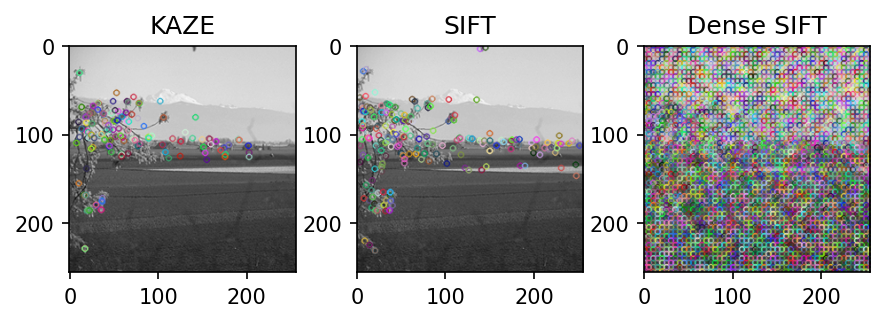

In [139]:
#Plot a sample of KAZE 
sift = cv2.KAZE_create()
filename=test_images_filenames[12]
ima=cv2.imread(filename)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

kpt,des=sift.detectAndCompute(gray,None)
img_keypoints_KAZE = cv2.drawKeypoints(gray, kpt, ima)


#Plot a sample of normal SIFT 
sift = cv2.SIFT_create()
filename=test_images_filenames[12]
ima=cv2.imread(filename)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

kpt,des=sift.detectAndCompute(gray,None)
img_keypoints_SIFT = cv2.drawKeypoints(gray, kpt, ima)


#Plot a sample of Dense SIFT 
sift = cv2.SIFT_create()
filename=test_images_filenames[12]
ima=cv2.imread(filename)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

step_size = 5
keypoints = []
for y in range(0, gray.shape[0], step_size):
    for x in range(0, gray.shape[1], step_size):
        keypoints.append(cv2.KeyPoint(x, y, 5))
_, descriptors = sift.compute(gray, keypoints)
img_keypoints_DSIFT = cv2.drawKeypoints(gray, keypoints, ima)


plot = plt.figure(figsize=(7,2), dpi=150)
plot.add_subplot(1,3, 1)
plt.imshow(img_keypoints_KAZE)
plt.title("KAZE")
plot.add_subplot(1,3, 2)
plt.imshow(img_keypoints_SIFT)
plt.title("SIFT")
plot.add_subplot(1,3, 3)
plt.imshow(img_keypoints_DSIFT)
plt.title("Dense SIFT")
plt.show(block=True)

### We test SIFT with different number of features

In [143]:
def test_detector(n_splits = n_splits, detector_name='SIFT', n_keypoints = [0], dense_sift=False, step_sizes=[5]):
  kf = KFold(n_splits=n_splits, shuffle=True)
  measures_by_fold = {
    'accuracies': [],
    'precisions': [],
    'recalls': [],
    'fscores': []
  }

  k = 260
  n = 5

  for i, (train_index, test_index) in enumerate(kf.split(X)):
    # print(f"Fold {i}:")
    
    accuracies = []
    precisions = []
    recalls = []
    fscores = []
    
    if n_keypoints != [0]:
      for n_keypoint in n_keypoints:        
        step_size = step_sizes[0]
        
        if detector_name == 'SIFT':
          detector = cv2.SIFT_create(n_keypoint)
        elif detector_name == 'KAZE':
          detector = cv2.KAZE_create(threshold=n_keypoint)

        Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, detector, dense_sift=dense_sift, step_size=step_size)
        
        codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)

        visual_words_test = get_visual_words_test(test_images_filenames, k, detector, codebook, dense_sift=dense_sift, step_size=step_size)

        knn, accuracy, precision, recall, fscore = compute_knn(n, 'euclidean', visual_words, train_labels, visual_words_test, test_labels, verbose=0)
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        fscores.append(fscore)
    else:
      for step_size in step_sizes:
        n_keypoint = n_keypoints[0]
        # Create a SIFT detector object
        detector = cv2.SIFT_create(n_keypoint)

        Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, detector, dense_sift=dense_sift, step_size=step_size)
        
        codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)

        visual_words_test = get_visual_words_test(test_images_filenames, k, detector, codebook, dense_sift=dense_sift, step_size=step_size)

        knn, accuracy, precision, recall, fscore = compute_knn(n, 'euclidean', visual_words, train_labels, visual_words_test, test_labels, verbose=0)
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        fscores.append(fscore)

  measures_by_fold['accuracies'].append(accuracies)
  measures_by_fold['precisions'].append(precisions)
  measures_by_fold['recalls'].append(recalls)
  measures_by_fold['fscores'].append(fscores) 

  accuracies_average = np.mean(measures_by_fold['accuracies'], axis=0)
  precisions_average = np.mean(measures_by_fold['precisions'], axis=0)
  recalls_average = np.mean(measures_by_fold['recalls'], axis=0)
  fscores_average = np.mean(measures_by_fold['fscores'], axis=0)
  
  return accuracies_average, precisions_average, recalls_average, fscores_average

n_keypoints = [100, 200, 500, 1000, 2500, 5000]
accuracies_average, precisions_average, recalls_average, fscores_average = test_detector(n_splits, 'SIFT', n_keypoints)

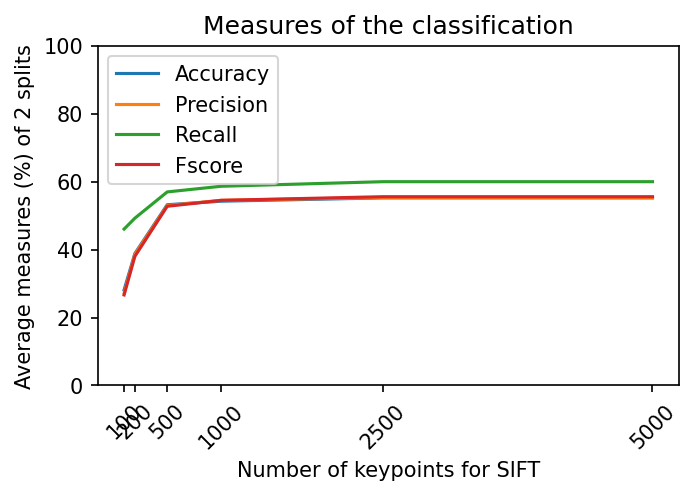

In [147]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(n_keypoints, accuracies_average)
plt.plot(n_keypoints, precisions_average)
plt.plot(n_keypoints, recalls_average)
plt.plot(n_keypoints, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("Number of keypoints for SIFT")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(n_keypoints, rotation='45')
plt.show()

Increasing the number of keypoints for SIFT increases the accuracy, precision and recall. However from 500 features onwards the metrics do not change that much, maybe because there is enough information for the classifier to perform good

### We now test KAZE with different thresholds

In [148]:
n_keypoints = [0.0001, 0.0005]
accuracies_average, precisions_average, recalls_average, fscores_average = test_detector(n_splits, 'KAZE', n_keypoints)

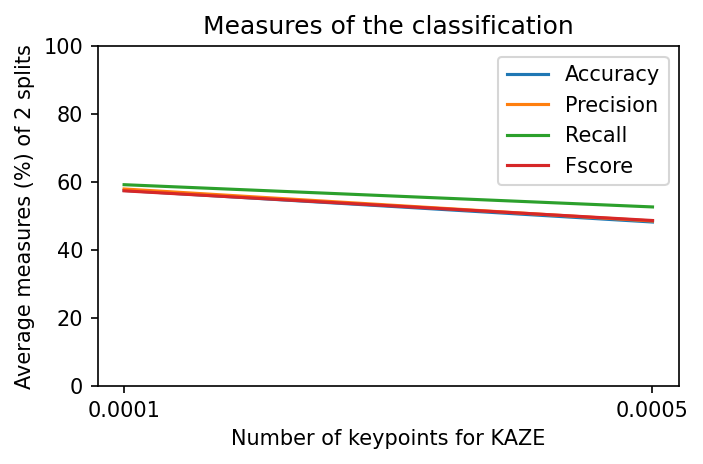

In [149]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(n_keypoints, accuracies_average)
plt.plot(n_keypoints, precisions_average)
plt.plot(n_keypoints, recalls_average)
plt.plot(n_keypoints, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("Number of keypoints for KAZE")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(n_keypoints)
plt.show()

Similar to SIFT by reducing the threshold (less threshold means more local features) we increase the accuracy of the algorithm

### Testing Dense SIFT with different step sizes

In [184]:
detector_name = 'SIFT'

step_sizes = [5, 25, 50, 200, 500, 1000]
accuracies_average, precisions_average, recalls_average, fscores_average = test_detector(n_splits, 'SIFT', [0], dense_sift=True, step_sizes=step_sizes)

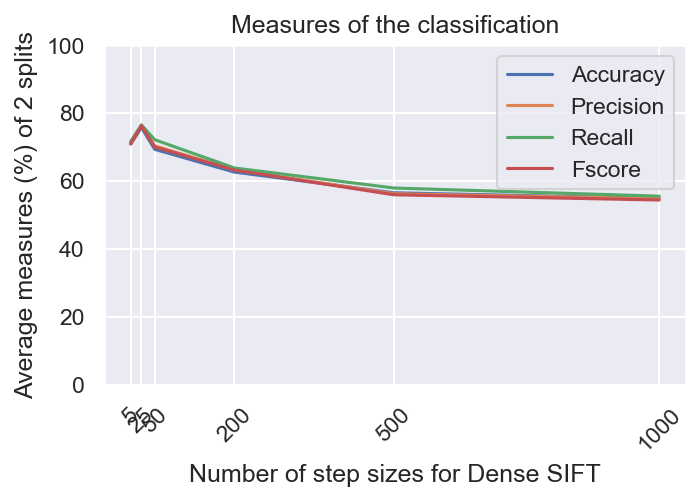

In [185]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(step_sizes, accuracies_average)
plt.plot(step_sizes, precisions_average)
plt.plot(step_sizes, recalls_average)
plt.plot(step_sizes, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("Number of step sizes for Dense SIFT")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(step_sizes, rotation='45')
plt.show()

Unlike the sparse coverage offered by the typical SIFT algorithm, Dense SIFT enables dense covering of the image as it computes the SIFT descriptor at a regular grid of points in the image.

It can be seen with our results that the performance using dense SIFT improves instead of using normal SIFT. We get a best accuracy of 76 % in comparison to the 60 % we got in the previous section. Similar to the results given by SIFT, dense SIFT increases the performance of the classifier as the number of features increase up to a point (step size decreasing).

# Testing different amounts of codebook size

We now test different numbers of k for the kmeans to get the visual words

In [168]:
measures_by_fold = {
  'accuracies': [],
  'precisions': [],
  'recalls': [],
  'fscores': []
}

codebook_sizes = list(range(10, 500, 50))
n = 5

for i, (train_index, test_index) in enumerate(kf.split(X)):  
  Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, Detector)

  accuracies = []
  precisions = []
  recalls = []
  fscores = []
  
  # Test different amounts of codebook sizes
  for k in codebook_sizes:
    codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)
    
    visual_words_test = get_visual_words_test(test_images_filenames, k, Detector, codebook)
    
    knn, accuracy, precision, recall, fscore = compute_knn(n, 'euclidean', visual_words, train_labels, visual_words_test, test_labels, verbose=0)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)

  measures_by_fold['accuracies'].append(accuracies)
  measures_by_fold['precisions'].append(precisions)
  measures_by_fold['recalls'].append(recalls)
  measures_by_fold['fscores'].append(fscores)

accuracies_average = np.mean(measures_by_fold['accuracies'], axis=0)
precisions_average = np.mean(measures_by_fold['precisions'], axis=0)
recalls_average = np.mean(measures_by_fold['recalls'], axis=0)
fscores_average = np.mean(measures_by_fold['fscores'], axis=0)

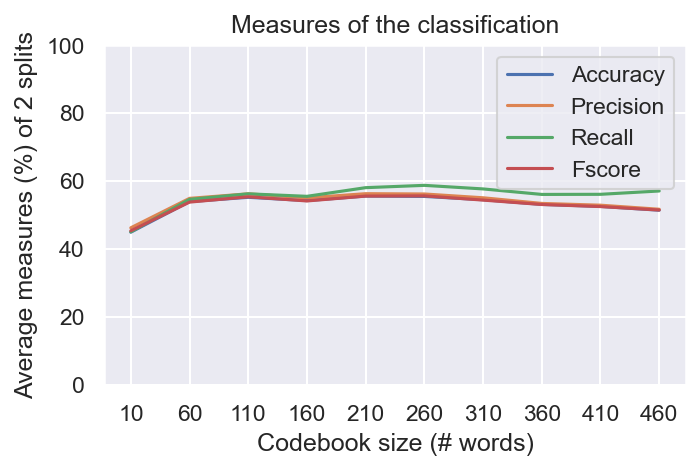

In [169]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(codebook_sizes, accuracies_average)
plt.plot(codebook_sizes, precisions_average)
plt.plot(codebook_sizes, recalls_average)
plt.plot(codebook_sizes, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("Codebook size (# words)")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(codebook_sizes)
plt.show()

best_codebook_size_index = np.argmax(accuracies_average)

The optimum size of the codebook among the ones tested is 260 words. We could test more values with smaller intervals (between 210 and 310 for example) but this experiment took more than 1 hour to execute. Overall a low number of codebook size reduces the performance of our algorithm, whether as after a codebook size of 60 the performance is steady.

# Testing different values of k for the k-NN classifier

In [170]:
measures_by_fold = {
  'accuracies': [],
  'precisions': [],
  'recalls': [],
  'fscores': []
}

best_knn = None

k = 260
ns = range(1, 19, 3)

for i, (train_index, test_index) in enumerate(kf.split(X)):
  Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, Detector)
  
  codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)
  
  visual_words_test = get_visual_words_test(test_images_filenames, k, Detector, codebook)

  # Save accuracies among different values of k for the k-NN classifier
  accuracies = []
  precisions = []
  recalls = []
  fscores = []
  best_accuracy = 0
  
  for n in ns:
    knn, accuracy, precision, recall, fscore = compute_knn(n, 'euclidean', visual_words, train_labels, visual_words_test, test_labels, verbose=0)
    
    if accuracy > best_accuracy:
      best_knn = knn
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    
  measures_by_fold['accuracies'].append(accuracies)
  measures_by_fold['precisions'].append(precisions)
  measures_by_fold['recalls'].append(recalls)
  measures_by_fold['fscores'].append(fscores)

accuracies_average = np.mean(measures_by_fold['accuracies'], axis=0)
precisions_average = np.mean(measures_by_fold['precisions'], axis=0)
recalls_average = np.mean(measures_by_fold['recalls'], axis=0)
fscores_average = np.mean(measures_by_fold['fscores'], axis=0)

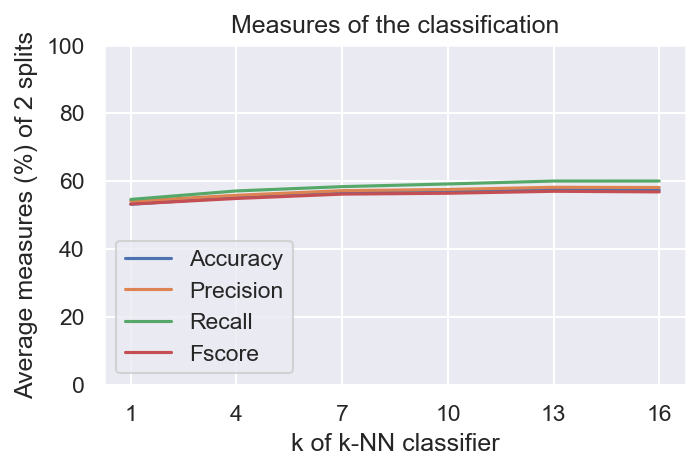

In [171]:
plt.figure(figsize=(5,3), dpi=150)

plt.plot(ns, accuracies_average)
plt.plot(ns, precisions_average)
plt.plot(ns, recalls_average)
plt.plot(ns, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("k of k-NN classifier")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(ns)
plt.show()

Using a *k* equal to 16 in the *k-NN* classifier gives the best accuracy. Increasing the number of k increases the overall performance of the algorithm

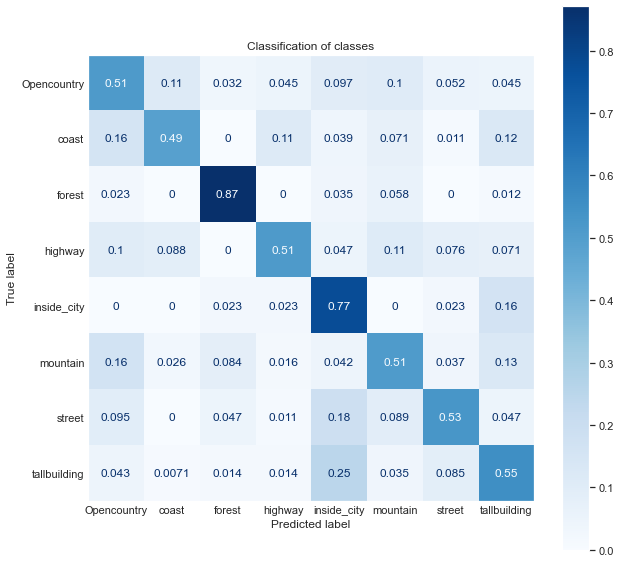

In [172]:
cm = confusion_matrix(best_knn.predict(visual_words_test), test_labels, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=best_knn.classes_)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Classification of classes")
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(b=False)
cmd.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='horizontal')

We compute the confusion matrix to see how well our algorithm classifies each class. By looking at the confusion matrix, we can see that the classes forest and inside city are the ones that our algorithm can classify best overall

In [173]:
test_labels_num = []
for index, label in enumerate(test_labels):
    test_labels_num.append(np.where(best_knn.classes_==label)[0][0])
    

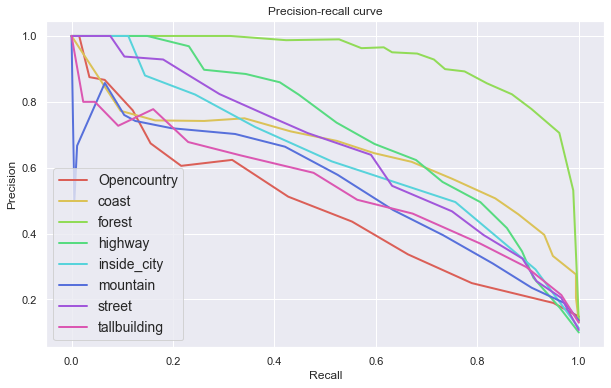

In [174]:
palette = sns.hls_palette(8)

test_labels_num = np.array(test_labels_num).astype('float64')
plt.figure(figsize=(10,6))
for i in range(best_knn.classes_.shape[0]):
    precision, recall, _ = precision_recall_curve(np.where(test_labels_num==i,1.0,0.0), best_knn.predict_proba(visual_words_test)[:,i])
    
    plt.plot(recall, precision, lw=2, color=palette[i], label=best_knn.classes_[i])
    
plt.title('Precision-recall curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(prop={'size': 14})

Text(0.5, 1.0, 't-SNE of the visual words used by the k-NN')

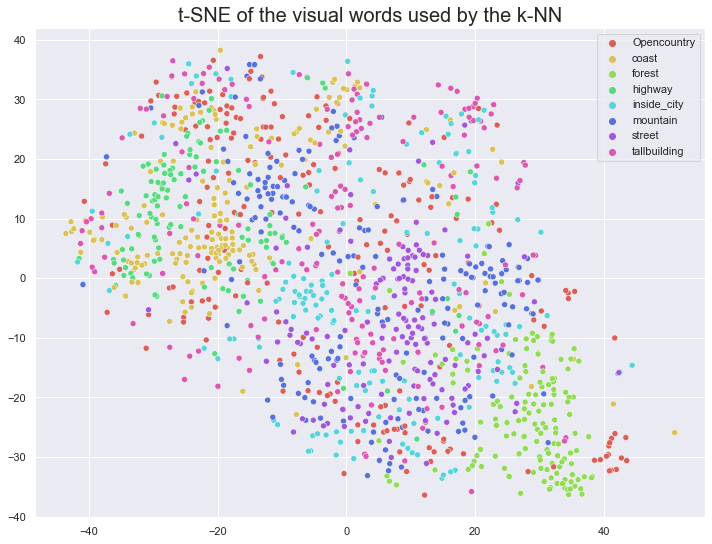

In [175]:
tsne = TSNE(n_components = 2, random_state=0)

tsne_res = tsne.fit_transform(visual_words, train_labels)

sns.set(rc={'figure.figsize':(12,9)})
s = sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = train_labels, palette=palette, legend='full')
s.set_title('t-SNE of the visual words used by the k-NN',size=20)

We can see that there exists a relationship between the Precision-Recall curve and the plot given by t-SNE. That is because of separability of the data shown by TSNE, the nearest group  data classes in high dimensional space correspond to a better precision-recall. For instance, the class forest (light-green) is more clustered on t-SNE and the one that has the best curve on precision-recall, whether as the class tallbuilding (pink) is more dispersed on the t-SNE plot and has one of the worsts precision-recall curves.

# Testing different distances for the kNN classifier

Given the best K and N given before we compare different kNN distance metrics

In [180]:
kf = KFold(n_splits=n_splits, shuffle=True)

measures_by_fold = {
  'accuracies': [],
  'precisions': [],
  'recalls': [],
  'fscores': []
}

k = 260
n = 16
metrics = ['hassanat', 'euclidean', 'cityblock', 'cosine']

for i, (train_index, test_index) in enumerate(kf.split(X)):
#   print(f"Fold {i}:")

  Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, Detector)

  codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)
      
  visual_words_test = get_visual_words_test(test_images_filenames, k, Detector, codebook)

  # Save accuracies among different distances  
  accuracies = {}
  precisions = {}
  recalls = {}
  fscores = {}
  
  for metric in metrics:
    knn, accuracy, precision, recall, fscore = compute_knn(n, metric, visual_words, train_labels, visual_words_test, test_labels)
    accuracies[metric] = accuracy
    precisions[metric] = precision
    recalls[metric] = recall
    fscores[metric] = fscore
    
  measures_by_fold['accuracies'].append(accuracies)
  measures_by_fold['precisions'].append(precisions)
  measures_by_fold['recalls'].append(recalls)
  measures_by_fold['fscores'].append(fscores)


accuracies_average = []
for fold in measures_by_fold['accuracies']:
    for index, (key, value) in enumerate(fold.items()):
        if  len(accuracies_average) <= index:
            accuracies_average.append(value)
        else:
            accuracies_average[index] += value
accuracies_average = np.array(accuracies_average)
accuracies_average /= n_splits

precisions_average = []
for fold in measures_by_fold['precisions']:
    for index, (key, value) in enumerate(fold.items()):
        if  len(precisions_average) <= index:
            precisions_average.append(value)
        else:
            precisions_average[index] += value
precisions_average = np.array(precisions_average)
precisions_average /= n_splits

recalls_average = []
for fold in measures_by_fold['recalls']:
    for index, (key, value) in enumerate(fold.items()):
        if  len(recalls_average) <= index:
            recalls_average.append(value)
        else:
            recalls_average[index] += value
recalls_average = np.array(recalls_average)
recalls_average /= n_splits

fscores_average = []
for fold in measures_by_fold['fscores']:
    for index, (key, value) in enumerate(fold.items()):
        if  len(fscores_average) <= index:
            fscores_average.append(value)
        else:
            fscores_average[index] += value
fscores_average = np.array(fscores_average)
fscores_average /= n_splits

<BarContainer object of 4 artists>

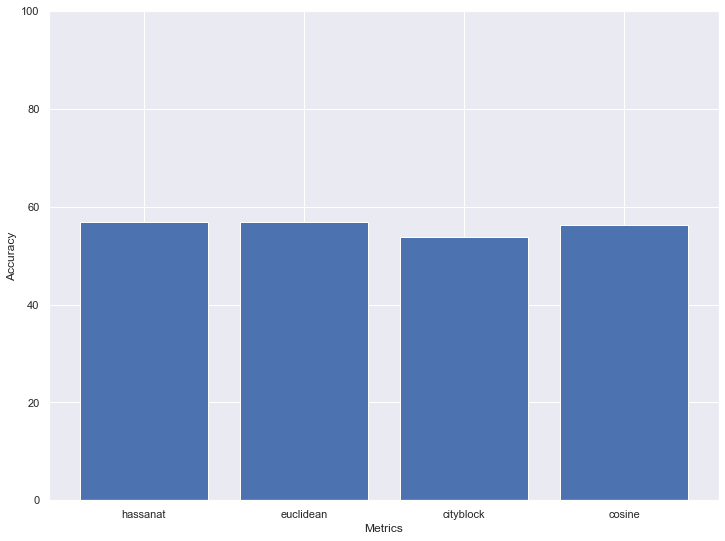

In [181]:
plt.figure
plt.ylim(0,100)
plt.ylabel('Accuracy')
plt.xlabel('Metrics')

plt.bar(metrics, accuracies_average)

We can observe using the bar plots that the accuracy among the different testing metrics is similar 

(0.0, 1.0, 0.0, 1.0)

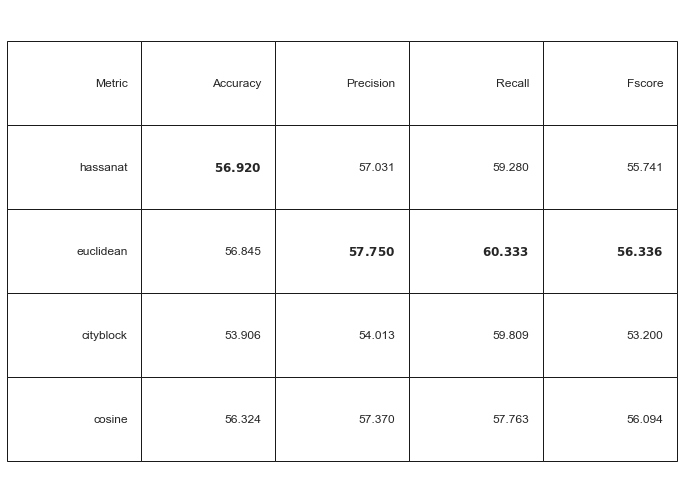

In [182]:
import matplotlib.pyplot as plt

accuracies_average_string = np.round(accuracies_average, 3)
accuracies_average_string = np.char.mod('%.3f', accuracies_average_string)
max_accuracy_index = np.argmax(accuracies_average_string)
accuracies_average_string = accuracies_average_string.tolist()    
accuracies_average_string[max_accuracy_index] = r"$\bf{" + accuracies_average_string[max_accuracy_index] + r"}$"

precisions_average_string = np.round(precisions_average, 3)
precisions_average_string = np.char.mod('%.3f', precisions_average_string)
max_accuracy_index = np.argmax(precisions_average_string)
precisions_average_string = precisions_average_string.tolist()    
precisions_average_string[max_accuracy_index] = r"$\bf{" + precisions_average_string[max_accuracy_index] + r"}$"

recalls_average_string = np.round(recalls_average, 3)
recalls_average_string = np.char.mod('%.3f', recalls_average_string)
max_accuracy_index = np.argmax(recalls_average_string)
recalls_average_string = recalls_average_string.tolist()    
recalls_average_string[max_accuracy_index] = r"$\bf{" + recalls_average_string[max_accuracy_index] + r"}$"

fscores_average_string = np.round(fscores_average, 3)
fscores_average_string = np.char.mod('%.3f', fscores_average_string)
max_accuracy_index = np.argmax(fscores_average_string)
fscores_average_string = fscores_average_string.tolist()    
fscores_average_string[max_accuracy_index] = r"$\bf{" + fscores_average_string[max_accuracy_index] + r"}$"

metrics_results = np.column_stack(np.vstack((metrics, accuracies_average_string, precisions_average_string, recalls_average_string, fscores_average_string)))

t = plt.table(cellText=[['Metric', 'Accuracy', 'Precision', 'Recall', 'Fscore'], *metrics_results], loc='center')
t.scale(1,7)
plt.axis('off')

The best metric by accuracy was the Hassanat distance whether as the best metric for precision, recall and f-score for kNN was the Euclidean distance. Overall no large differences were found between all metrics. However this may change in other datasets as explained in "Effects of Distance Measure Choice on K-Nearest Neighbor Classifier Performance: A Review" (https://www.liebertpub.com/doi/abs/10.1089/big.2018.0175?journalCode=big)

# Dimensionality reduction

We perform dimensionality reduction, with PCA and LDA

### PCA

In [186]:
measures_by_fold = {
  'accuracies': [],
  'precisions': [],
  'recalls': [],
  'fscores': []
}


k = 260
n = 16
n_components = [2, 32, 64, 128, 260]

for i, (train_index, test_index) in enumerate(kf.split(X)):
  # print(f"Fold {i}:")
  
  Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, Detector)
  
  codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)
  
  # Save accuracies among different values of k for the k-NN classifier
  accuracies = []
  precisions = []
  recalls = []
  fscores = []
  
  for n_component in n_components:
    pca = PCA(n_components=n_component)
  
    visual_words_test = get_visual_words_test(test_images_filenames, k, Detector, codebook)
    
    visual_words_pca = pca.fit_transform(visual_words)
    visual_words_test_pca = pca.transform(visual_words_test)
    
    knn, accuracy, precision, recall, fscore = compute_knn(n, 'euclidean', visual_words_pca, train_labels, visual_words_test_pca, test_labels, verbose=0)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    
  measures_by_fold['accuracies'].append(accuracies)
  measures_by_fold['precisions'].append(precisions)
  measures_by_fold['recalls'].append(recalls)
  measures_by_fold['fscores'].append(fscores)

accuracies_average = np.mean(measures_by_fold['accuracies'], axis=0)
precisions_average = np.mean(measures_by_fold['precisions'], axis=0)
recalls_average = np.mean(measures_by_fold['recalls'], axis=0)
fscores_average = np.mean(measures_by_fold['fscores'], axis=0)

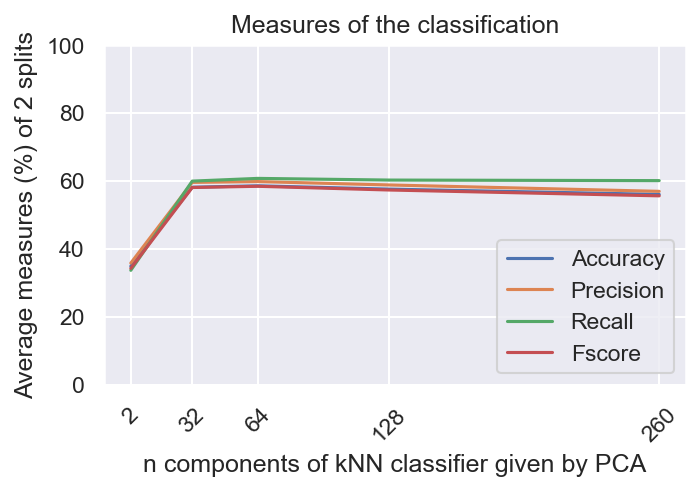

In [187]:
plt.figure(figsize=(5,3), dpi=150)

plt.plot(n_components, accuracies_average)
plt.plot(n_components, precisions_average)
plt.plot(n_components, recalls_average)
plt.plot(n_components, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("n components of kNN classifier given by PCA")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(n_components, rotation='45')
plt.show()

Reducing the dimensionality with PCA makes almost no change in accuracy up to a point. However it decreases drastically when the number of dimensions are reduced a lot (to 2 for instance). PCA is useful to increase the speed of the classification algorithm or for visualization purposes

### LDA

In [188]:
measures_by_fold = {
  'accuracies': [],
  'precisions': [],
  'recalls': [],
  'fscores': []
}


k = 260
n = 5
n_components = [1,2,3,4,5]

for i, (train_index, test_index) in enumerate(kf.split(X)):
  # print(f"Fold {i}:")
  
  Train_descriptors, train_labels, test_labels, train_images_filenames, test_images_filenames, D = get_descriptors(train_index, test_index, Detector)
  
  codebook, words, visual_words = compute_kmeans(D, Train_descriptors, k)
  
  # Save accuracies among different values of k for the k-NN classifier
  accuracies = []
  precisions = []
  recalls = []
  fscores = []
  
  for n_component in n_components:
    lda = LinearDiscriminantAnalysis(n_components=n_component)
  
    visual_words_test = get_visual_words_test(test_images_filenames, k, Detector, codebook)
    
    visual_words_lda = lda.fit_transform(visual_words,train_labels)
    visual_words_test_lda = lda.transform(visual_words_test)
    
    knn, accuracy, precision, recall, fscore = compute_knn(n, 'euclidean', visual_words_lda, train_labels, visual_words_test_lda, test_labels, verbose=0)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    
  measures_by_fold['accuracies'].append(accuracies)
  measures_by_fold['precisions'].append(precisions)
  measures_by_fold['recalls'].append(recalls)
  measures_by_fold['fscores'].append(fscores)

accuracies_average = np.mean(measures_by_fold['accuracies'], axis=0)
precisions_average = np.mean(measures_by_fold['precisions'], axis=0)
recalls_average = np.mean(measures_by_fold['recalls'], axis=0)
fscores_average = np.mean(measures_by_fold['fscores'], axis=0)

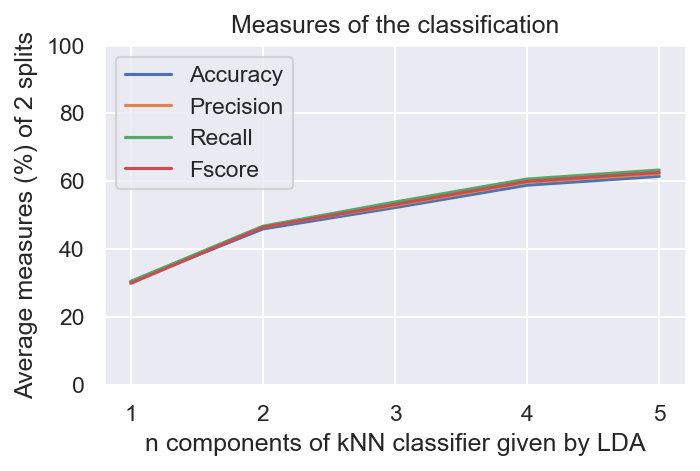

In [189]:
plt.figure(figsize=(5,3), dpi=150)

plt.plot(n_components, accuracies_average)
plt.plot(n_components, precisions_average)
plt.plot(n_components, recalls_average)
plt.plot(n_components, fscores_average)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("n components of kNN classifier given by LDA")
plt.ylabel(f"Average measures (%) of {n_splits} splits")
plt.xticks(n_components)
plt.show()

In LDA the more components LDA has, the more accuracy the algorithm has. Overall the accuracy monotonically increases with the number of components.

In comparison with PCA, LDA always reduces the accuracy of the algorithm with less components whether as PCA accuracy stays steady up to a constant, where it decreases drastically.

# Conclusion

In this work we have seen how different hyperparameters and algorithms change the performance of a Bag of Words algorithm. Several local features extractors, number of k's of kmeans, kNN measures and dimensionality reduction techniques have been tested. Overall the algorithm improves a lot with Dense SIFT, a specific number of codebook size (260) and a k (16) of kNN. The codebook size and the k hyperparameter could be discovered by using hyperparameter optimization algorithms such as Optuna.   